## Figures for analysis of combined single cells
This notebook reproduces Figures S4D-E

In [35]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
from copy import deepcopy
import pickle
import phenograph
from scipy.stats import entropy


In [37]:
%matplotlib inline

<h3> Load data </h3>

In [38]:
out_dir = '/home/chanj3/data/Prostate.LP.publication.010122/out.single_cell.combined.010122/'

In [39]:
adata = sc.read_h5ad(out_dir + 'adata.single_cell.combined.010122.h5ad')

In [31]:
adata

AnnData object with n_obs × n_vars = 15677 × 14617
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'time', 'treatment', 'Basal vs Luminal by Correlation', 'MUT_WT', 'Basal Correlation', 'batch_plus_wt_cells', 'metacell_assignment', 'metacell_centers', 'pval_markov_Basal_Org1', 'pval_markov_Basal_Org2', 'pval_markov_Basal_Org3', 'pval_markov_Luminal_Org1', 'pval_markov_Luminal_Org2'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'batch_plus_wt_cells_colors', 'diffmap_evals_pca', 'neighbors', 'num_components', 'paga', 'rank_genes_groups', 'var_explained'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'imputed

In [7]:
ind_mc_dir = '/home/chanj3/data/Prostate.LP.publication.010122/out.metacells.individual.010122/'

adata_mc_dict = {}
for fn in glob.glob(ind_mc_dir + '*/adata*h5ad'):
    sample = os.path.basename(fn).split('.')[2]
    adata_mc_dict[sample] = sc.read_h5ad(fn)

In [8]:
ind_sc_dir = '/home/chanj3/data/Prostate.LP.publication.010122/out.single_cell.individual.010122/'     
    
adata_sc_dict = {}
for j in adata_mc_dict.keys():
    ind_sc_fn = ind_sc_dir + '%s/adata.single_cell.%s.010122.h5ad' % (j, j)
    adata_sc_dict[j] = sc.read_h5ad(ind_sc_fn)
    

### Figure S8E

In [139]:
sc.set_figure_params(fontsize=20)


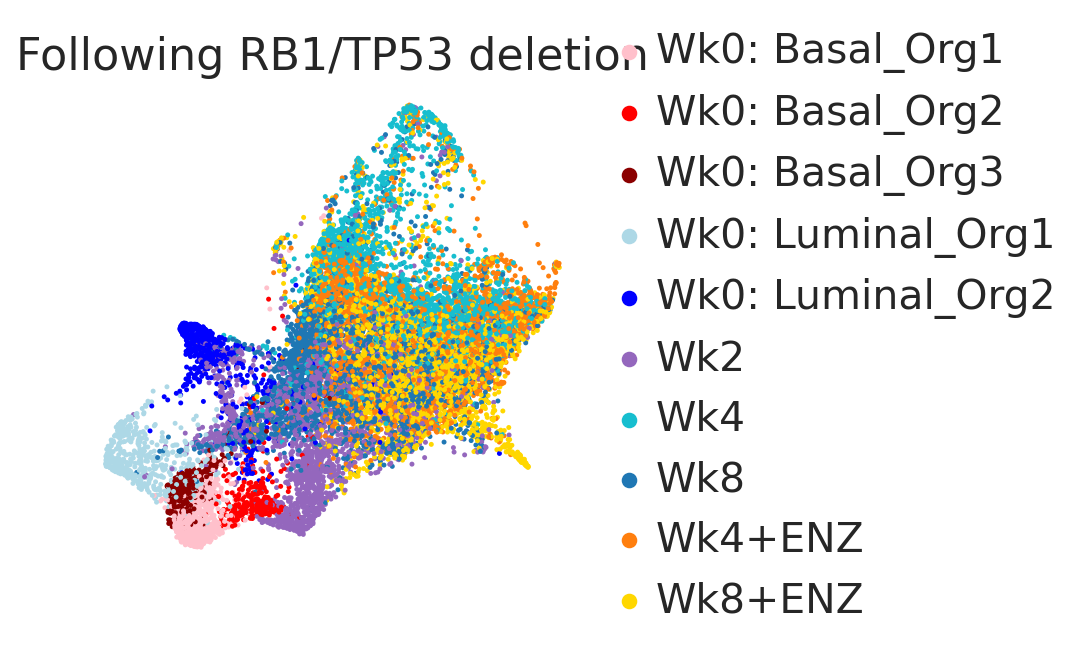

In [148]:
sc.pl.draw_graph(
    adata,
    color=['batch_plus_wt_cells'],
    frameon=False, use_raw = False,
    sort_order=False, vmax = 5, title = 'Following RB1/TP53 deletion', layout = 'fa',
    ncols=2, s=20
)

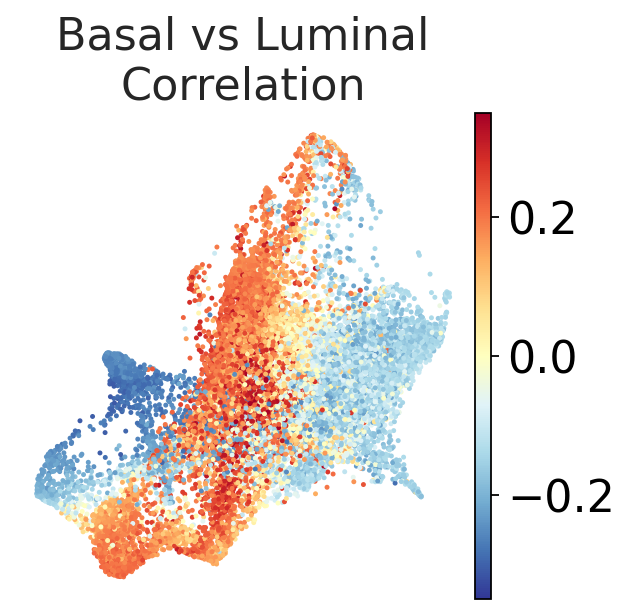

In [163]:
sc.set_figure_params(fontsize=20, dpi_save = 300)
sc.pl.draw_graph(
    adata,
    color=['Basal Correlation'],
    color_map='RdYlBu_r',
    frameon=False, use_raw = False,
    sort_order=False, #vmax = 5,
    ncols=2, s=20, vmin = -0.35, vmax = 0.35, title = 'Basal vs Luminal\nCorrelation',
    layout = 'fa'
)

### Fig S8G

In [12]:
from scipy.stats import zscore
from itertools import chain

In [13]:
mc_dir = '/home/chanj3/data/Prostate.LP.publication.010122/out.metacells.combined.010122/'

In [14]:
deg_dir = mc_dir + 'MAST.MUT_WT.BL_stratify/'
mut_wt_b_df = pd.read_csv(deg_dir + 'deg.mast.MUT_WT.CD49f_only.filtered.csv', sep =',', index_col = 'primerid')





In [15]:
ind1 = mut_wt_b_df.loc[:,'Bonferroni.Padj'] < 0.05
ind2 = mut_wt_b_df.coef > np.log2(1.5)
mut_wt_b_up = mut_wt_b_df.index[ind1.values & ind2.values]
ind2 = mut_wt_b_df.coef < -np.log2(1.5)
mut_wt_b_dn = mut_wt_b_df.index[ind1.values & ind2.values]

mut_wt_b = mut_wt_b_up.union(mut_wt_b_dn)



In [16]:
deg_dir = mc_dir + 'MAST.MUT_WT.BL_stratify/'
mut_wt_l_df = pd.read_csv(deg_dir + 'deg.mast.MUT_WT.CD24_only.filtered.csv', sep =',', index_col = 'primerid')



In [17]:
ind1 = mut_wt_l_df.loc[:,'Bonferroni.Padj'] < 0.05
ind2 = mut_wt_l_df.coef > np.log2(1.5)
mut_wt_l_up = mut_wt_l_df.index[ind1.values & ind2.values]
ind2 = mut_wt_l_df.coef < -np.log2(1.5)
mut_wt_l_dn = mut_wt_l_df.index[ind1.values & ind2.values]

mut_wt_l = mut_wt_l_up.union(mut_wt_l_dn)



In [11]:
sc.set_figure_params(fontsize=16)


In [12]:
b_select_genes = ['KRT5','KRT14','KRT17', 'AXL','BEX3','SOX4','SOX6','IFITM3','LY6C1','ALYREF','NFIB','NFIC','ID3','SERPINE2','WNT10A','BCAM','ITGA3','ITGA6','ITGB1','ITGB4','ITGB1BP1','INHBA','DLK2','LGALS7','NOTCH1','VCAM1','SMAD1','VEGFB','HES6','H2AFV','H2AFZ','HMGB1','HMGB2','HMGB3','STMN1','TOP2A','CDCA2','RAD51']
l_select_genes = ['PSCA','KRT4','KRT78','CD24A','AGR2','PROM1','KRT18','KRT8','LY6D','LY6E','KRT7','KRT13','KRT10','KRT19','ALCAM','CLDN3','LGALS3']
bl_select_genes  = b_select_genes + l_select_genes


In [13]:
ct_dict = {'Basal gained': [i for i in b_select_genes if i in mut_wt_b_up],
           'Luminal gained': [i for i in l_select_genes if i in mut_wt_l_up],
           'Basal lost': [i for i in b_select_genes if i in mut_wt_b_dn],
           'Luminal lost': [i for i in l_select_genes if i in mut_wt_l_dn],
           'EMT gained': ['VIM','FN1','COL4A1','COL4A2','ZEB1','ZEB2','TWIST1'] #,'TWIST2']
}

In [14]:
gene_list = list(chain(*[ct_dict[i] for i in ct_dict.keys()])) 

In [15]:
ind_bl = adata.obs.loc[:,'Basal vs Luminal by Correlation']=='CD24'

In [17]:
norm_df = pd.DataFrame(adata.X, index=adata.obs.index, columns = adata.var.index).loc[ind_bl,:]
sub_df = norm_df.loc[:,gene_list].groupby(adata.obs.batch[ind_bl], axis=0).agg(lambda x: x.mean())
mat = (sub_df-sub_df.min())/(sub_df.max()-sub_df.min())

idx = np.argsort(mat.loc[:,ct_dict['Basal gained']].loc['Wk2'])
b_up = list(np.array(ct_dict['Basal gained'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Luminal gained']].loc['Wk2'])
l_up = list(np.array(ct_dict['Luminal gained'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Basal lost']].loc['Wk2'])
b_dn = list(np.array(ct_dict['Basal lost'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Luminal lost']].loc['Wk2'])
l_dn = list(np.array(ct_dict['Luminal lost'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['EMT gained']].loc['Wk2'])
emt = list(np.array(ct_dict['EMT gained'])[idx])

ct_dict = {'Basal\nmarkers\ngained': b_up,
           'EMT\nmarkers\ngained': emt, 
           'Luminal\nmarkers\nlost': l_dn,

}

In [18]:
gene_list = list(chain.from_iterable(list(ct_dict.values())))

ct_pos = [[i for i,j in enumerate(gene_list) if j in val] for val in ct_dict.values()]
ct_pos = [(i[0],i[0]) if len(i)==1 else (i[0],i[-1]) for i in ct_pos]

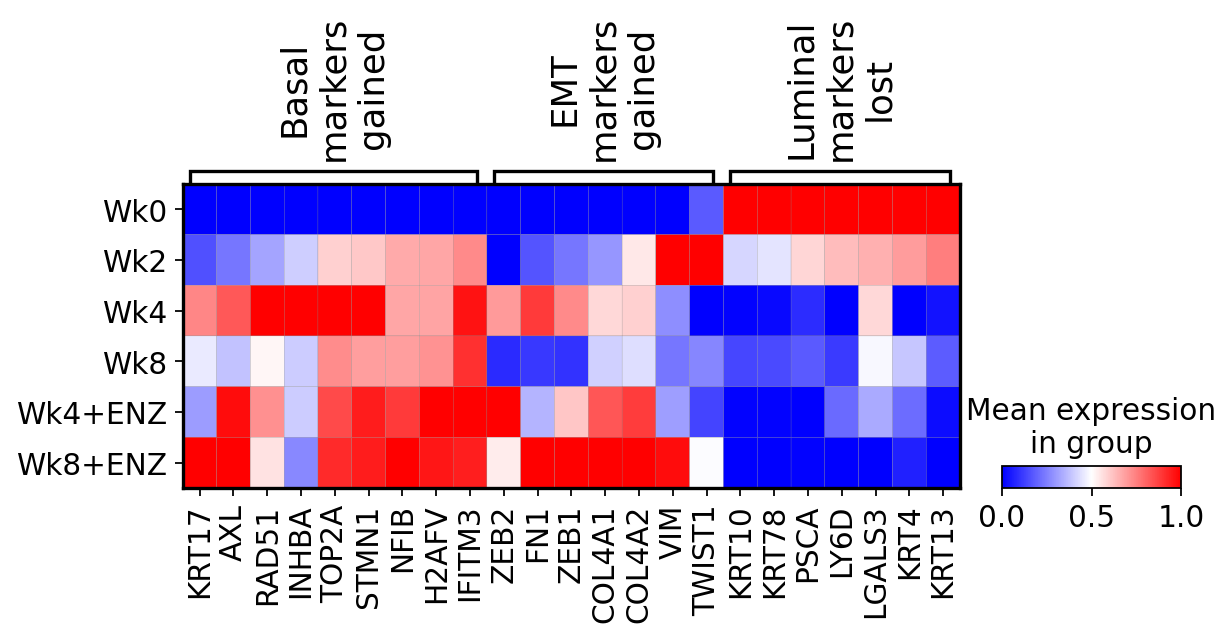

In [19]:
ax = sc.pl.matrixplot(adata[ind_bl,:], gene_list, groupby='batch', dendrogram=False,
                   var_group_positions=ct_pos, use_raw = False, standard_scale = 'var',
                   var_group_labels=list(ct_dict.keys()), cmap = 'bwr', vmin = 0,
                   figsize=(8,2.5))


In [20]:
ct_dict = {'Basal gained': [i for i in b_select_genes if i in mut_wt_b_up],
           'Luminal gained': [i for i in l_select_genes if i in mut_wt_l_up],
           'Basal lost': [i for i in b_select_genes if i in mut_wt_b_dn],
           'Luminal lost': [i for i in l_select_genes if i in mut_wt_l_dn],
           'EMT gained': ['VIM','FN1','COL4A1','COL4A2','ZEB1','ZEB2','TWIST1'] 
}

In [21]:
gene_list = list(chain(*[ct_dict[i] for i in ct_dict.keys()]))

In [22]:
ind_bl = adata.obs.loc[:,'Basal vs Luminal by Correlation']=='CD49f'

In [23]:
norm_df = pd.DataFrame(adata.X, index=adata.obs.index, columns = adata.var.index).loc[ind_bl,:]
sub_df = norm_df.loc[:,gene_list].groupby(adata.obs.batch[ind_bl], axis=0).agg(lambda x: x.mean())
mat = (sub_df-sub_df.min())/(sub_df.max()-sub_df.min())

idx = np.argsort(mat.loc[:,ct_dict['Basal gained']].loc['Wk2'])
b_up = list(np.array(ct_dict['Basal gained'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Luminal gained']].loc['Wk2'])
l_up = list(np.array(ct_dict['Luminal gained'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Basal lost']].loc['Wk2'])
b_dn = list(np.array(ct_dict['Basal lost'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['Luminal lost']].loc['Wk2'])
l_dn = list(np.array(ct_dict['Luminal lost'])[idx])

idx = np.argsort(mat.loc[:,ct_dict['EMT gained']].loc['Wk2'])
emt = list(np.array(ct_dict['EMT gained'])[idx])

ct_dict = {
           'Luminal\nmarkers\ngained': l_up,
           'EMT\nmarkers\ngained': emt,
    'Basal\nmarkers\nlost': b_dn,
}

In [24]:
gene_list = list(chain.from_iterable(list(ct_dict.values())))

ct_pos = [[i for i,j in enumerate(gene_list) if j in val] for val in ct_dict.values()]
ct_pos = [(i[0],i[0]) if len(i)==1 else (i[0],i[-1]) for i in ct_pos]

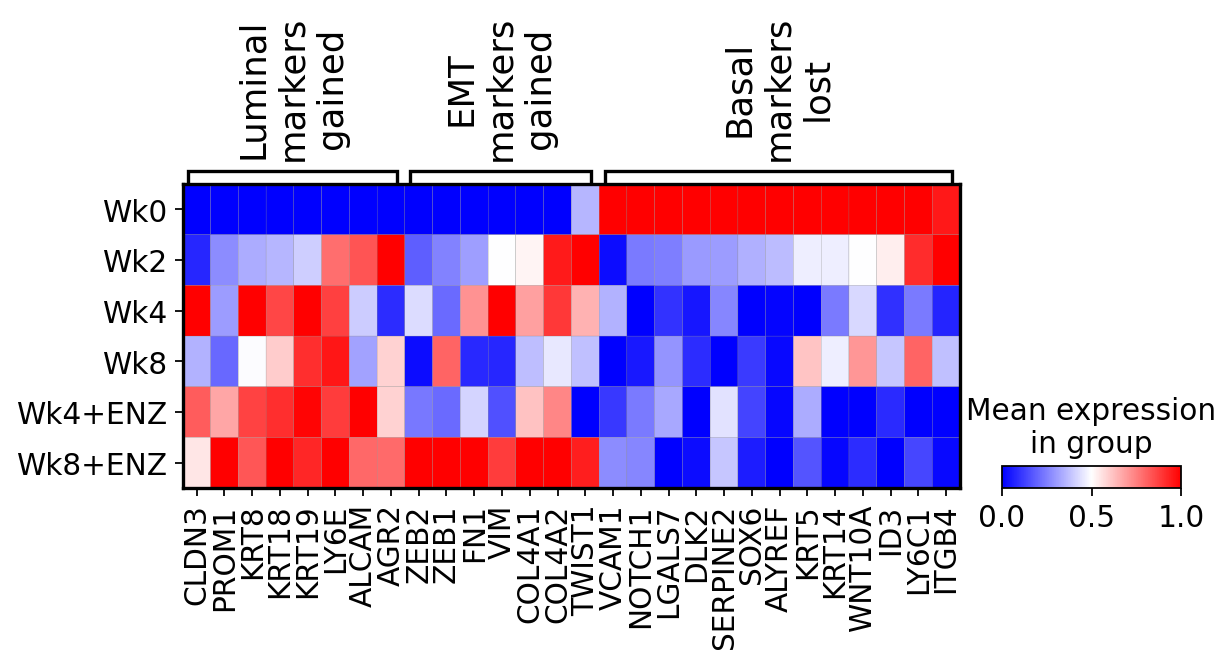

In [25]:
ax = sc.pl.matrixplot(adata[ind_bl,:], gene_list, groupby='batch', dendrogram=False,
                   var_group_positions=ct_pos, use_raw = False, standard_scale = 'var',
                   var_group_labels=list(ct_dict.keys()), cmap = 'bwr', vmin = 0,
                   figsize=(8,2.5))


### Figure 3E, Table S12

In [18]:
gmt_dir = '/data/peer/chanj3/ref/genelists/'
filter_genes = []
for term in ['apoptosis','hypoxia','cell_cycle']:
    gmt = gmt_dir + term + '.gmt'
    with open(gmt,'r') as f:
        lines = f.readlines()
        for line in lines:
            filter_genes += line.strip().split('\t')[2:]

In [19]:
filter_paths = ['HALLMARK_INTERFERON_ALPHA_RESPONSE',
                'HALLMARK_INTERFERON_GAMMA_RESPONSE',
                'HALLMARK_IL6_JAK_STAT3_SIGNALING',
               'FGFR_signature.Acevedo_etal', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']


In [20]:
gmt_dir = '/home/chanj3/data/Prostate_Organoid.LP.publication.100121/ref/'
# gmt_fn = paste0(gmt_dir, 'curated.100121.gmt')
gmt_fn = gmt_dir + 'curated.010122.gmt'

with open(gmt_fn,'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.split('\t')[0] in filter_paths:
            filter_genes += line.strip().split('\t')[2:]

In [21]:
mut_wt_l_up2 = mut_wt_l_up[~mut_wt_l_up.isin(filter_genes)]
mut_wt_b_up2 = mut_wt_b_up[~mut_wt_b_up.isin(filter_genes)]

In [22]:
ind_dir='/home/chanj3/data/SCPC_transformation.metacells.resubmission.010122/out.cell_line.individual.010122/'


In [23]:
df = pd.read_csv(ind_dir + 'DHT_0/MAST.Basal_vs_Luminal/Basal_vs_Luminal.CD49f.csv', index_col=0)
df.loc[:,'Bonferroni.Padj'] = [min(1,i) for i in df.loc[:,'Pr(>Chisq)']*df.shape[0]]
ind2 = df.loc[:,'Bonferroni.Padj'] < 0.05

ind1 = df.coef > np.log2(1.5)
b_all =  df.loc[ind1.values & ind2.values ,:].sort_values('coef',ascending=False)
b_all = b_all.loc[b_all.primerid.isin(mut_wt_l_up2),:]

ind1 = df.coef < -np.log2(1.5)
l_all =  df.loc[ind1.values & ind2.values ,:].sort_values('coef',ascending=True)
l_all = l_all.loc[l_all.primerid.isin(mut_wt_b_up2),:]


In [24]:
b_all.to_csv(out_dir + 'B_up.MUT_vs_WT.MAST.csv',sep = ',')


In [70]:
l_all.to_csv(out_dir + 'L_up.MUT_vs_WT.MAST.csv',sep = ',')

In [25]:
b_all = pd.read_csv(out_dir + 'B_up.MUT_vs_WT.MAST.csv', sep = ',')

In [26]:
l_all = pd.read_csv(out_dir + 'L_up.MUT_vs_WT.MAST.csv', sep = ',')

In [27]:
num_degs = 150


b = b_all.sort_values('coef',ascending=False).primerid.values[:num_degs]

l = l_all.sort_values('coef',ascending=True).primerid.values[:num_degs]



In [85]:
from scipy.stats import zscore

In [86]:
imp_merge = pd.DataFrame(adata.layers['imputed'], index=adata.obs.index, columns = adata.var_names)

In [87]:
z1 = imp_merge.loc[:, l].apply(zscore).mean(axis=1)
z2 = imp_merge.loc[:, b].apply(zscore).mean(axis=1)

In [175]:
adata.obs.loc[:,'MUT_plus_wt_bl'] = adata.obs.batch

In [176]:
adata.obs.loc[:,'MUT_plus_wt_bl'] = adata.obs.loc[:,'MUT_plus_wt_bl'].astype(str)

In [177]:
adata.obs.loc[adata.obs.loc[:,'MUT_plus_wt_bl'].str.contains('[248]'),'MUT_plus_wt_bl'] = 'Mutant'

In [178]:
adata.obs.loc[adata.obs.MUT_plus_wt_bl=='Wk0','MUT_plus_wt_bl'] = 'Wk0: ' + adata.obs.loc[adata.obs.MUT_plus_wt_bl=='Wk0','Basal vs Luminal by Correlation'].astype(str)


In [179]:
adata.obs.MUT_plus_wt_bl = adata.obs.MUT_plus_wt_bl.astype('category')

In [107]:
plot_df = pd.DataFrame({'Luminal Z-score': z1, 'Basal Z-score': z2, 'Condition': adata.obs.MUT_plus_wt_bl})

In [108]:
sc.set_figure_params(fontsize=18)
sns.set_style('ticks')

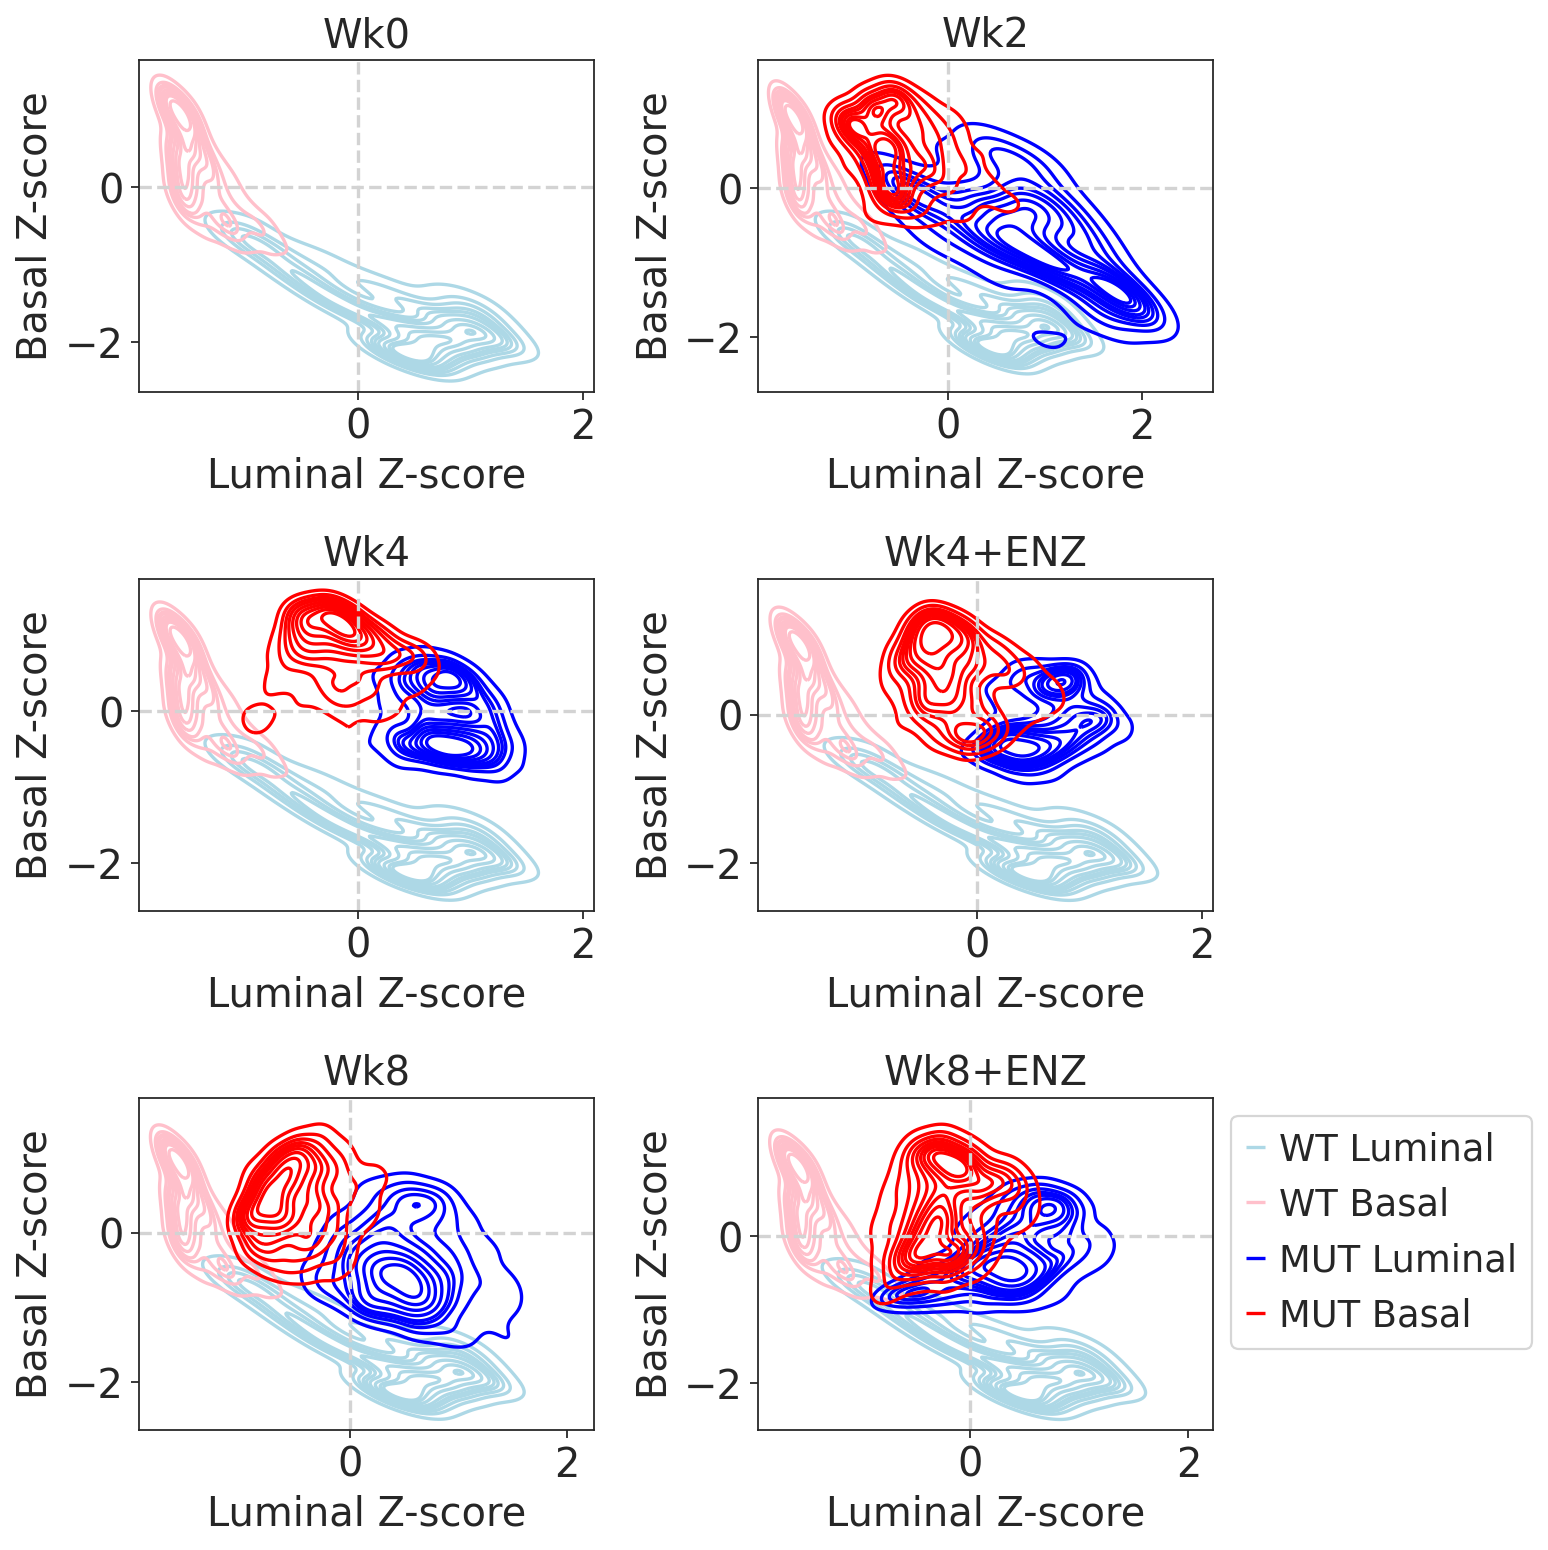

In [110]:
fig, axes = plt.subplots(3,2, figsize = (10,10))

for ax, sample in zip(np.ravel(axes), adata.obs.batch.cat.categories):

    sns.kdeplot(data = plot_df.loc[plot_df.Condition=='Wk0: CD24',:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='WT Luminal', ax=ax, color='lightblue')
    sns.kdeplot(data = plot_df.loc[plot_df.Condition=='Wk0: CD49f',:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='WT Basal', ax=ax, color='pink')
    if sample!='Wk0':
        ind1 = adata.obs.batch==sample
        ind2 = adata.obs.loc[:,'Basal vs Luminal by Correlation'] == 'CD49f'
        
        sns.kdeplot(data = plot_df.loc[ind1.values & ~ind2.values,:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='MUT Luminal', ax=ax, color = 'blue')
        sns.kdeplot(data = plot_df.loc[ind1.values & ind2.values,:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='MUT Basal', ax=ax, color = 'red')
    ax.axvline(x=0, linestyle='--', color='lightgray')
    ax.axhline(y=0, linestyle='--', color='lightgray')
    ax.set_title(sample)
ax.legend(bbox_to_anchor=(1,1), loc = 'upper left')
plt.tight_layout()


### Figure 3F

In [111]:
from scipy.stats import zscore
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment


In [130]:
d_lsap = pd.DataFrame(0, index=np.arange(100), columns = sorted(set(adata.obs.batch)))
for sample in adata.obs.batch.cat.categories:
    ind1 = adata.obs.batch==sample
    sub_mat = imp_merge.apply(zscore).loc[ind1,list(b)+list(l)]
    
    ind2 = adata.obs.loc[ind1,'Basal vs Luminal by Correlation'] == 'CD49f'
    for n in range(100):
        b_data = sub_mat.loc[ind2,:]
        l_data = sub_mat.loc[~ind2,:]
        Y1 = b_data.iloc[np.random.randint(0, b_data.shape[0], 100),:]
        Y2 = l_data.iloc[np.random.randint(0, l_data.shape[0], 100),:]
        d = cdist(Y1, Y2)
        assignment = linear_sum_assignment(d)
        d_lsap.loc[n,sample] = d[assignment].mean()

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [131]:
d_lsap = d_lsap.melt(var_name = 'Sample', value_name = 'Distance after LSAP')

In [137]:
d_lsap.Sample = d_lsap.Sample.astype('category').cat.reorder_categories(adata.obs.batch.cat.categories)

In [171]:
sns.set_style('ticks')

Text(0, 0.5, 'Mean Distance after LSAP')

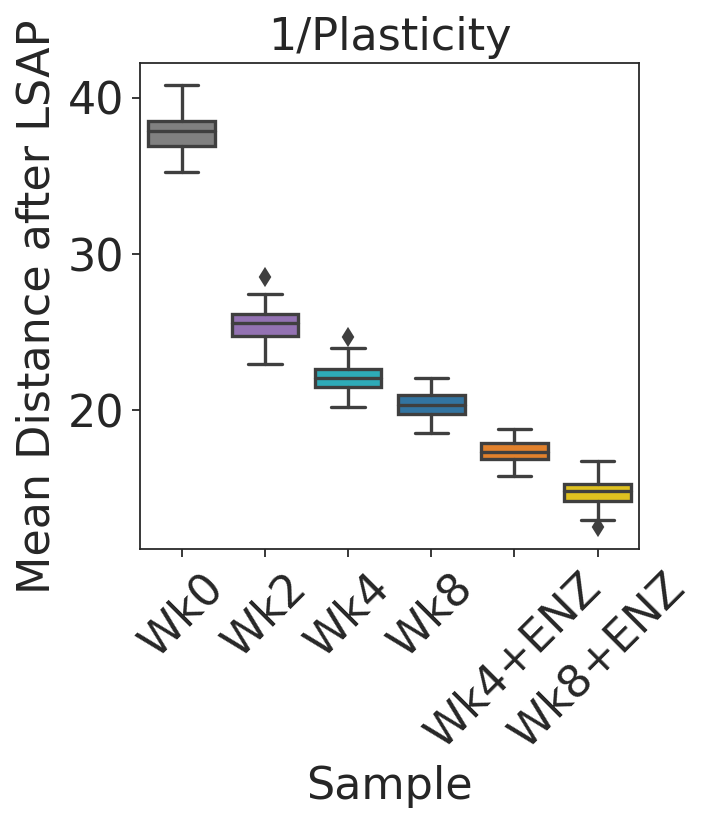

In [172]:
ax = sns.boxplot(data=d_lsap, x='Sample', y='Distance after LSAP',
                palette = ['gray'] + list(adata.uns['batch_plus_wt_cells_colors'][-5:]))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title('1/Plasticity')
ax.set_ylabel('Mean Distance after LSAP')

### Figure S9A

In [28]:
num_degs = 150

b = b_all.sort_values('coef',ascending=False).primerid.values[:num_degs]
l = l_all.sort_values('coef',ascending=True).primerid.values[:num_degs]


In [29]:
from scipy.stats import zscore

In [30]:
norm_df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var_names)

In [31]:
z1 = norm_df.loc[:, l].apply(zscore).mean(axis=1)
z2 = norm_df.loc[:, b].apply(zscore).mean(axis=1)

In [32]:
adata.obs.loc[:,'MUT_plus_wt_bl'] = adata.obs.batch

In [33]:
adata.obs.loc[:,'MUT_plus_wt_bl'] = adata.obs.loc[:,'MUT_plus_wt_bl'].astype(str)

In [34]:
adata.obs.loc[adata.obs.loc[:,'MUT_plus_wt_bl'].str.contains('[248]'),'MUT_plus_wt_bl'] = 'Mutant'

In [35]:
adata.obs.loc[adata.obs.MUT_plus_wt_bl=='Wk0','MUT_plus_wt_bl'] = 'Wk0: ' + adata.obs.loc[adata.obs.MUT_plus_wt_bl=='Wk0','Basal vs Luminal by Correlation'].astype(str)


In [36]:
adata.obs.MUT_plus_wt_bl = adata.obs.MUT_plus_wt_bl.astype('category')

In [37]:
plot_df = pd.DataFrame({'Luminal Z-score': z1, 'Basal Z-score': z2, 'Condition': adata.obs.MUT_plus_wt_bl})

In [38]:
sc.set_figure_params(fontsize=18)
sns.set_style('ticks')

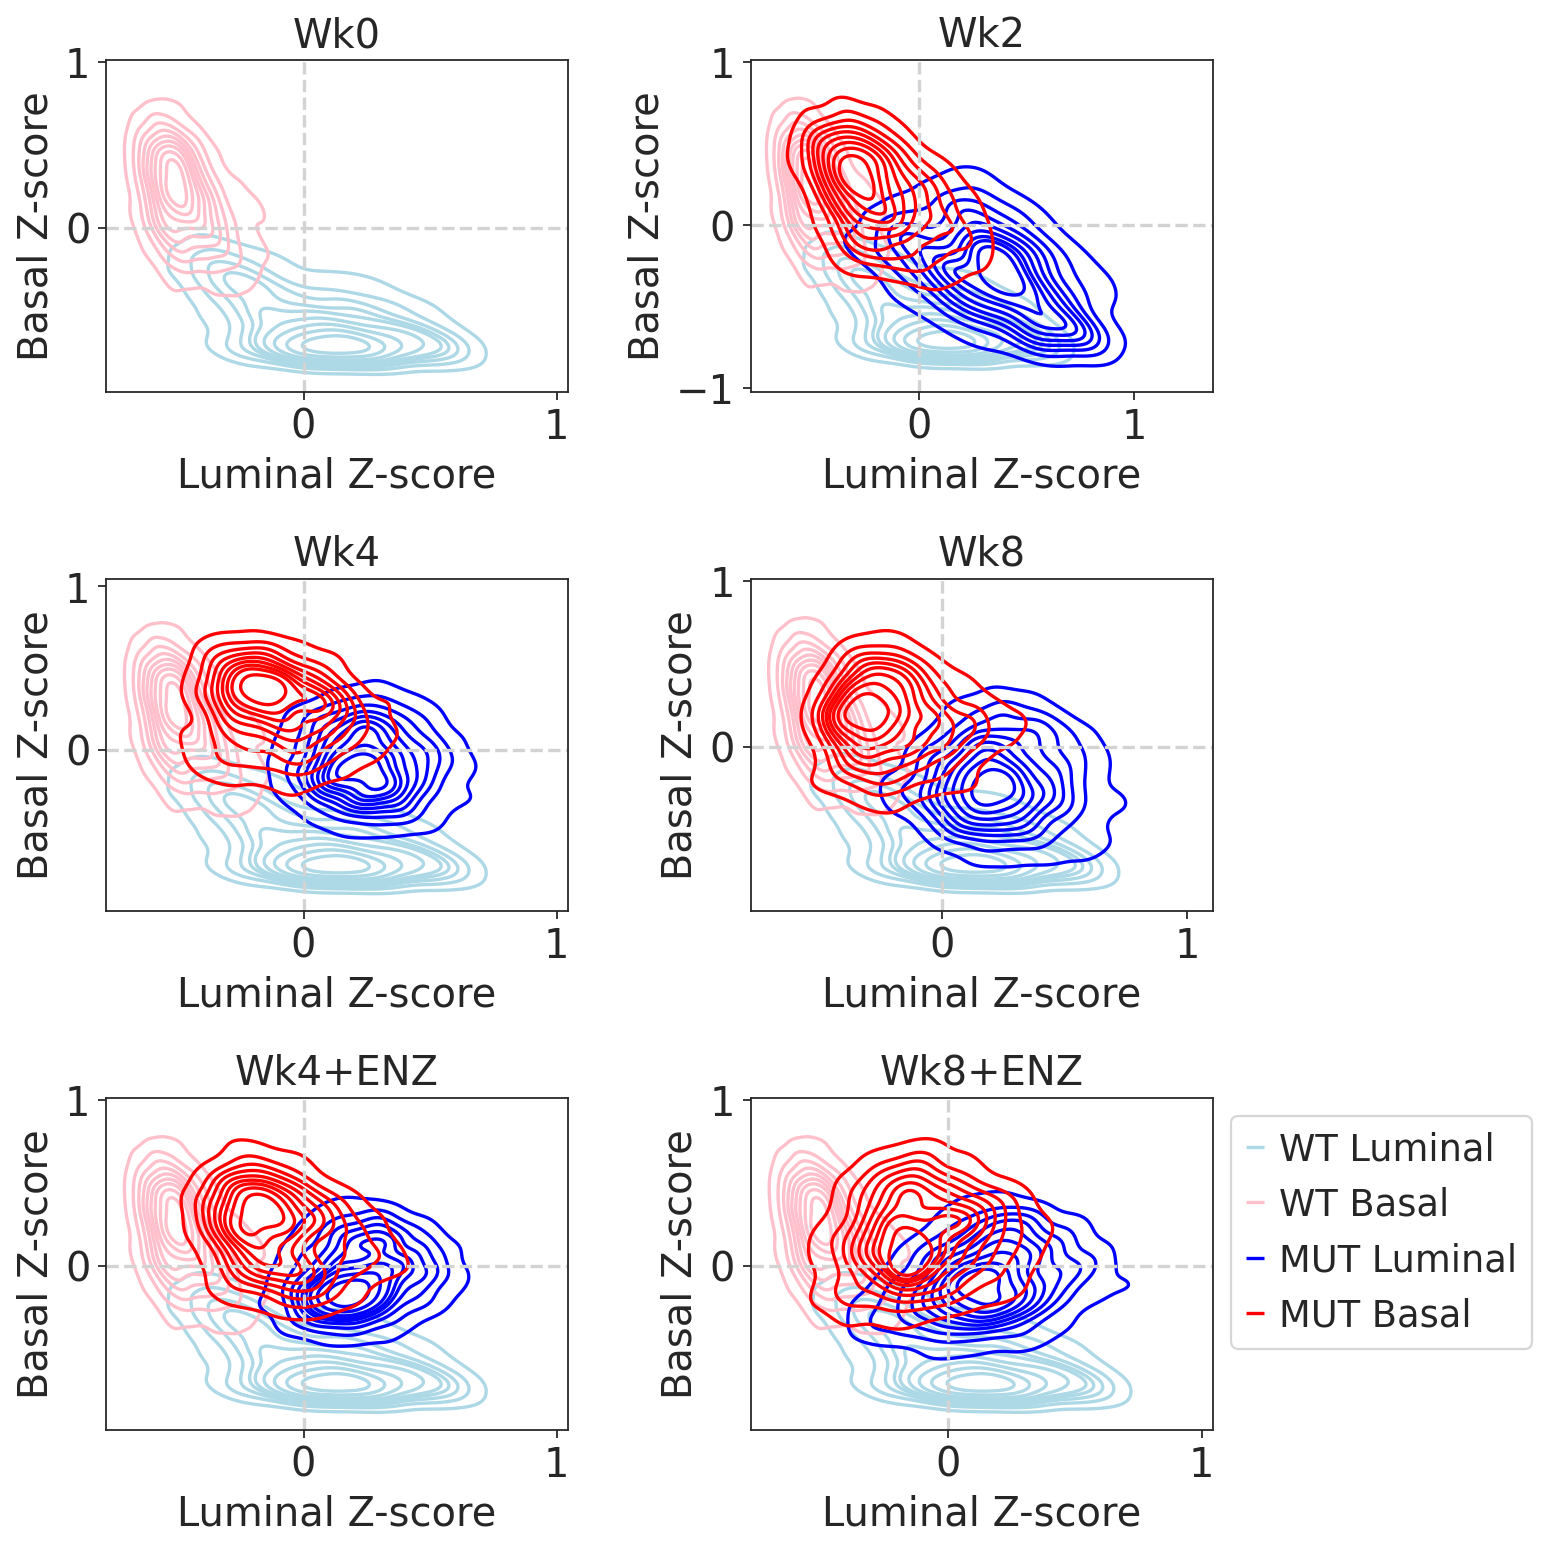

In [39]:
fig, axes = plt.subplots(3,2, figsize = (10,10))

for ax, sample in zip(np.ravel(axes), adata.obs.batch.cat.categories):

    sns.kdeplot(data = plot_df.loc[plot_df.Condition=='Wk0: CD24',:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='WT Luminal', ax=ax, color='lightblue')
    sns.kdeplot(data = plot_df.loc[plot_df.Condition=='Wk0: CD49f',:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='WT Basal', ax=ax, color='pink')
    if sample!='Wk0':
        ind1 = adata.obs.batch==sample
        ind2 = adata.obs.loc[:,'Basal vs Luminal by Correlation'] == 'CD49f'
        
        sns.kdeplot(data = plot_df.loc[ind1.values & ~ind2.values,:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='MUT Luminal', ax=ax, color = 'blue')
        sns.kdeplot(data = plot_df.loc[ind1.values & ind2.values,:], 
                                   x='Luminal Z-score', y='Basal Z-score', label='MUT Basal', ax=ax, color = 'red')
    ax.axvline(x=0, linestyle='--', color='lightgray')
    ax.axhline(y=0, linestyle='--', color='lightgray')
    ax.set_title(sample)
ax.legend(bbox_to_anchor=(1,1), loc = 'upper left')
plt.tight_layout()


### Figure S9B

In [98]:
from scipy.stats import zscore, pearsonr


In [185]:
num_degs = 150

b = b_all.sort_values('coef',ascending=False).primerid.values[:num_degs]
l = l_all.sort_values('coef',ascending=True).primerid.values[:num_degs]


In [180]:
d_lsap_dict = {}
for num_degs in range(100,210,10):

    b = b_all.sort_values('coef',ascending=False).primerid.values[:num_degs]
    l = l_all.sort_values('coef',ascending=True).primerid.values[:num_degs]

    z1 = imp_merge.loc[:, l].apply(zscore).mean(axis=1)
    z2 = imp_merge.loc[:, b].apply(zscore).mean(axis=1)

    plot_df = pd.DataFrame({'Luminal Z-score': z1, 'Basal Z-score': z2, 'Condition': adata.obs.MUT_plus_wt_bl})
    
    d_lsap = pd.DataFrame(0, index=np.arange(100), columns = sorted(set(adata.obs.batch)))
    for sample in adata.obs.batch.cat.categories:
        ind1 = adata.obs.batch==sample
        sub_mat = imp_merge.apply(zscore).loc[ind1,list(b)+list(l)]

        ind2 = adata.obs.loc[ind1,'Basal vs Luminal by Correlation'] == 'CD49f'
        for n in range(100):
            b_data = sub_mat.loc[ind2,:]
            l_data = sub_mat.loc[~ind2,:]
            Y1 = b_data.iloc[np.random.randint(0, b_data.shape[0], 100),:]
            Y2 = l_data.iloc[np.random.randint(0, l_data.shape[0], 100),:]
            d = cdist(Y1, Y2)
            assignment = linear_sum_assignment(d)
            d_lsap.loc[n,sample] = d[assignment].mean()
            
    d_lsap_dict[num_degs] = d_lsap

In [182]:
from scipy.stats import pearsonr

In [183]:
corr_mat = pd.DataFrame(0, index=range(100,210,10), columns = range(100,210,10))
for i in range(100,210,10):
    for j in range(100,210,10):
        corr_mat.loc[i,j] = pearsonr(d_lsap_dict[i].mean(), d_lsap_dict[j].mean())[0]


Text(39.777777777777786, 0.5, 'Number of Top DEGs')

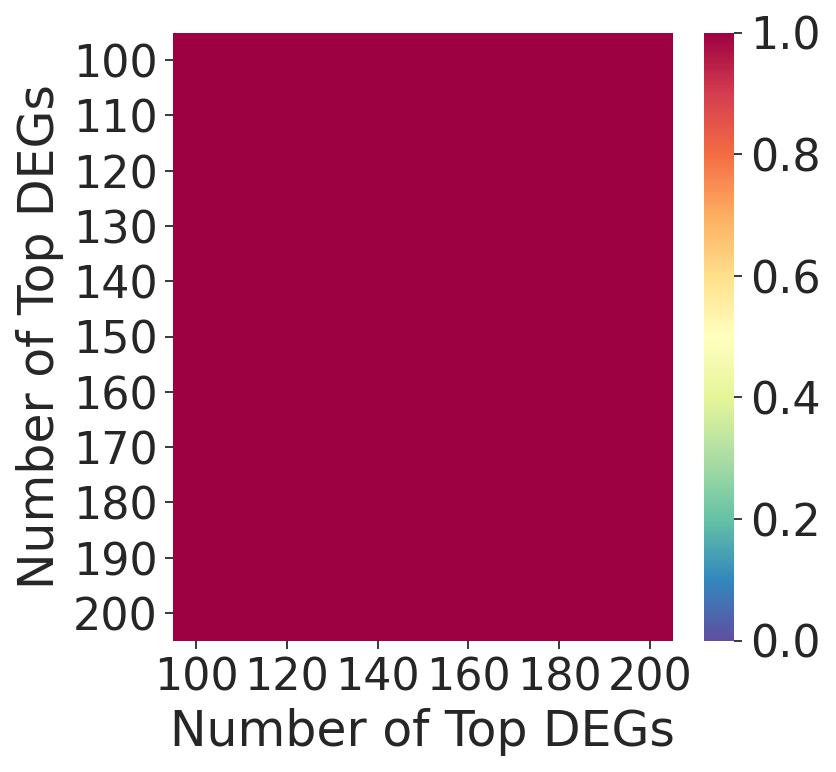

In [184]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(corr_mat, vmin=0, vmax=1,  cmap = 'Spectral_r', ax=ax)
ax.set_xlabel('Number of Top DEGs', fontsize=22)
ax.set_ylabel('Number of Top DEGs', fontsize=22)


### Figure S10A

In [40]:
n_neighbors = 25
num_dcs = 18

In [41]:
adata_sc = adata_sc_dict['Wk0']
adata_mc = adata_mc_dict['Wk0']

In [42]:
ct_dict = adata_mc.obs.cell_type
ct_dict.index = ct_dict.index.astype(int)


In [43]:
tp0_cell_type = adata_sc.obs.metacell_assignment.map(ct_dict)

In [44]:
dm_merge = pd.DataFrame(adata.obsm['X_diffmap_wtdeg'],
                        index = adata.obs.index).loc[:,:num_dcs]


In [45]:
cell_types = sorted(tp0_cell_type.cat.categories)
train = np.empty((len(cell_types),),dtype=object)
for c,cell_type in enumerate(cell_types):
    labels = tp0_cell_type.index[tp0_cell_type == cell_type]
    ind = [adata.obs.index.get_loc(i) for i in labels]
    train[c] = dm_merge.iloc[ind,:]
test = dm_merge 


In [46]:
ct_metacluster_preds_dm = phenograph.classify(train, test, k=n_neighbors, metric='euclidean')

pval_df = pd.DataFrame(ct_metacluster_preds_dm[1],
                                               index = test.index,
                                               columns = cell_types)


Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm


In [47]:
pval_df.columns = 'pval_markov_' + pval_df.columns

In [48]:
tmp = pval_df.subtract(pval_df.min(axis=1), axis=0)
pval_df = tmp.div(tmp.sum(axis=1), axis=0)

In [63]:
for i in pval_df.columns:
    adata.obs.loc[:, i] = pval_df.loc[:,i]

In [50]:
labels = ['pval_markov_Basal_Org1', 'pval_markov_Basal_Org2', 'pval_markov_Basal_Org3',
       'pval_markov_Luminal_Org1', 'pval_markov_Luminal_Org2']


In [51]:
plot_df = adata.obs.loc[adata.obs.batch != 'Wk0', labels].melt(var_name = 'Cell Type', value_name = 'p-value')
plot_df.loc[:,'Cell Type'] = plot_df.loc[:,'Cell Type'].str.replace('pval_markov_','')

In [52]:
sc.set_figure_params(fontsize = 20)

In [53]:
sns.set_style('ticks')

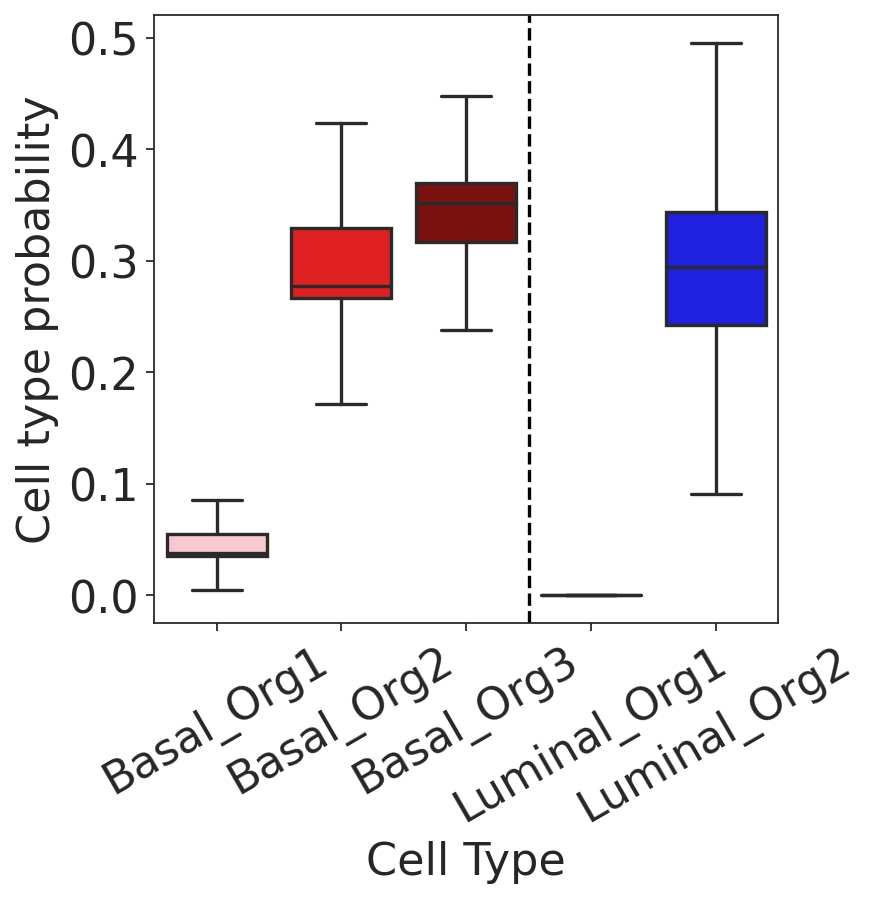

In [54]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
sns.boxplot(data = plot_df, x = 'Cell Type', y = 'p-value', ax=ax, 
            palette = ['pink','red','darkred','lightblue','blue'], showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.set_ylabel('Cell type probability')
ax.axvline(x=2.5, color = 'black', linestyle='--')

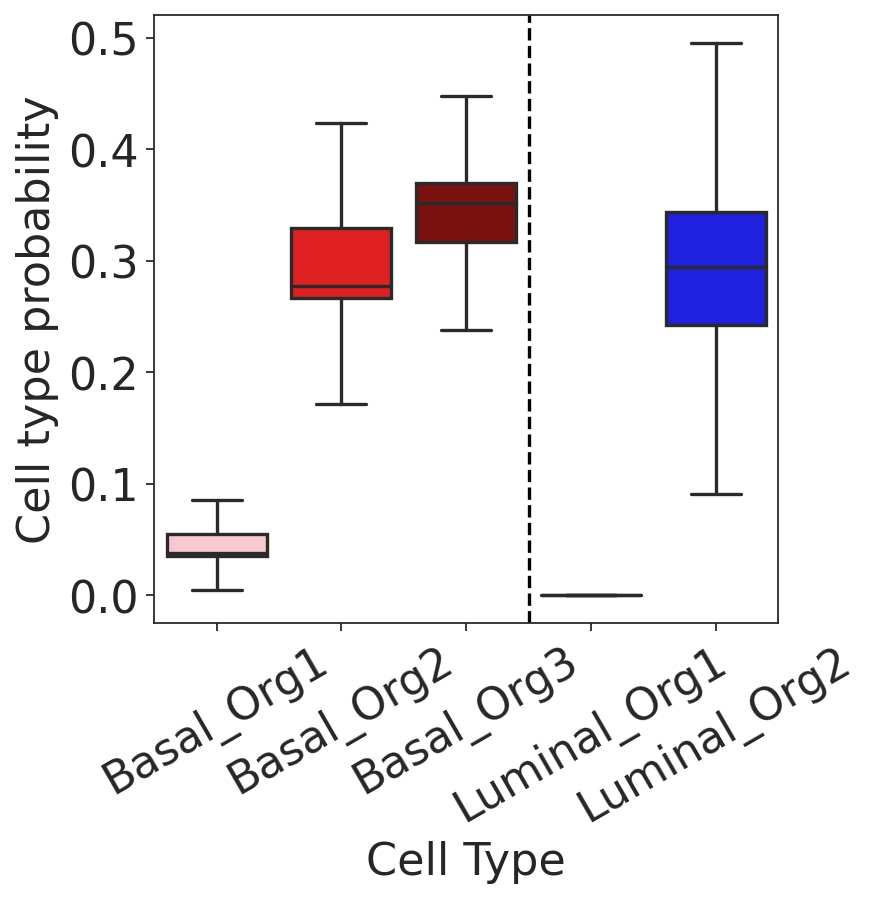

In [162]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
sns.boxplot(data = plot_df, x = 'Cell Type', y = 'p-value', ax=ax, 
            palette = ['pink','red','darkred','lightblue','blue'], showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.set_ylabel('Cell type probability')
ax.axvline(x=2.5, color = 'black', linestyle='--')

### Figure S10C

In [65]:
H = pval_df.apply(entropy, axis=1)

In [66]:
adata.obs.loc[:,'plasticity_markov_entropy'] = H

In [123]:
adata.obs.loc[:,'plasticity_markov_entropy'].to_frame(name = 'Entropy').to_csv(out_dir + 'entropy.MarkovAbsorption.010122.txt', sep = '\t')

In [59]:
plot_df = adata.obs.loc[:,['batch','time','treatment']]

In [60]:
plot_df.loc[:,'H'] = H.loc[plot_df.index]

In [61]:
plot_df.columns = ['Sample','Timepoint','Treatment','Entropy']

Text(0, 0.5, 'Entropy of\ncell type probabilities')

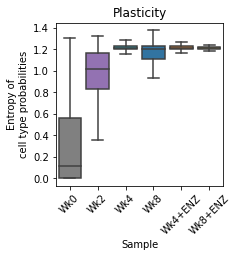

In [27]:
fig, ax= plt.subplots(1,1,figsize=(3,3))
sns.boxplot(data=plot_df, x='Sample', y='Entropy', ax=ax,showfliers = False,
                palette = ['gray'] + list(adata.uns['batch_plus_wt_cells_colors'][-5:]))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title('Plasticity')
ax.set_ylabel('Entropy of\ncell type probabilities')

### Figure S10E

In [200]:
plot_df = adata.obs.loc[adata.obs.batch.str.contains('[48]'),adata.obs.columns.str.contains('pval_markov')]

In [201]:
plot_df = plot_df.loc[:, plot_df.columns.str.contains('Basal_Org[23]|Luminal_Org2')]

In [202]:
plot_df = plot_df.div(plot_df.sum(axis=1), axis=0)

In [203]:
plot_df.loc[:,'batch'] = adata.obs.loc[adata.obs.batch.str.contains('[48]'), 'batch']

In [204]:
plot_df.loc[:,'batch'] = plot_df.loc[:,'batch'].astype(str).astype('category')

In [206]:
tally_df = plot_df.loc[plot_df.pval_markov_Luminal_Org2 > 0.6,'batch'].value_counts()
tally_df = tally_df.loc[tally_df!=0]
tally_df.index = tally_df.index.astype(str).astype('category')

In [207]:
total_df = plot_df.batch.value_counts()


In [208]:
tally_df = tally_df.div(total_df)

In [209]:
tally_df

Wk4        0.045027
Wk4+ENZ    0.011579
Wk8        0.106691
Wk8+ENZ    0.008852
Name: batch, dtype: float64

In [210]:
sc.set_figure_params(fontsize=20)
sns.set_style('ticks')

In [227]:
plot_df = pd.DataFrame({'Treatment': np.array(['Untreated','ENZ-treated'])[1*tally_df.index.str.contains('ENZ')],
                       'Time': tally_df.index.str.replace('\+ENZ','').str.replace('Wk','Week '),
                       'Proportion': tally_df})

In [228]:
plot_df

,Treatment,Time,Proportion
Wk4,Untreated,Week 4,0.045027
Wk4+ENZ,ENZ-treated,Week 4,0.011579
Wk8,Untreated,Week 8,0.106691
Wk8+ENZ,ENZ-treated,Week 8,0.008852


Text(0, 0.5, 'Fraction of\nLuminal Org2 cells')

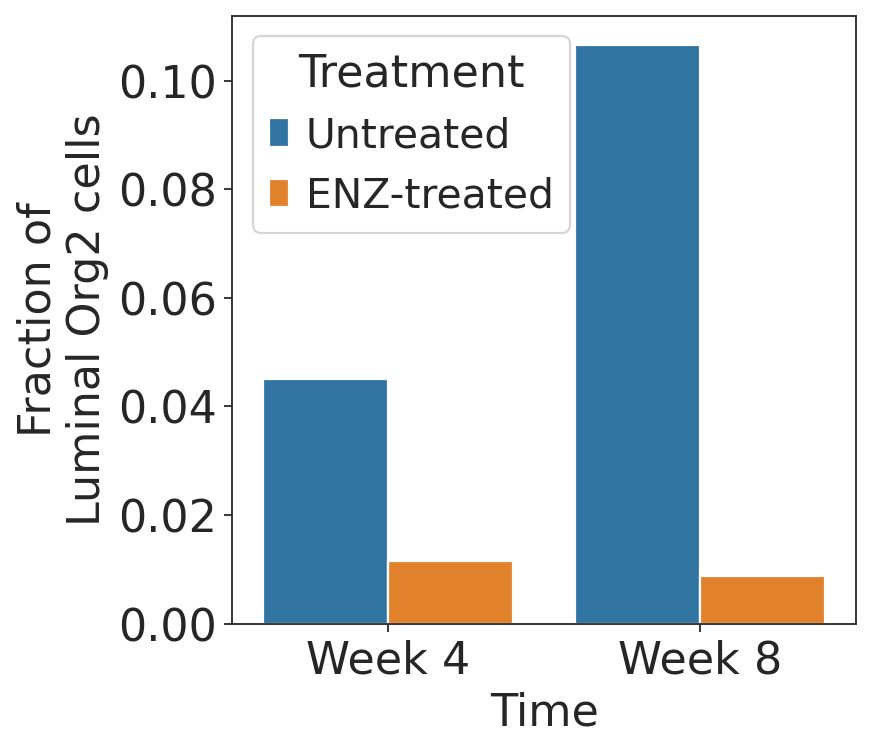

In [229]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(data = plot_df, y= 'Proportion', x = 'Time', 
            hue='Treatment', ax=ax)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Fraction of\nLuminal Org2 cells', fontsize=20)

